In [1]:
import pandas as pd
from Kernels.src.Analysis.Clustering import *
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score
import itertools
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.mosaicplot import mosaic
import lifelines
import statsmodels.api as sm
import itertools
from scipy import stats
import plotly.graph_objects as go
from matplotlib.offsetbox import AnchoredText
import matplotlib.font_manager as fm


# Functions

In [2]:
fontPath = "/CTGlab/home/danilo/.fonts/Inter-VariableFont_wght.ttf" 

In [3]:
def plotSankey(df: pd.DataFrame, cols: list, names=None,linkVar=None, valueToHighlight=None):
    """
    Plot a Sankey diagram based on the given dataframe and columns.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the data.
    - cols (list): A list of column names to use for plotting.
    - linkVar (str): The name of the column to use as a link variable (optional).
    - valueToHighlight: The value in the link variable to highlight (optional).

    Returns:
    - fig: The generated plotly figure object.
    """
    colsToPlot = []
    for col in cols:
       colsToPlot.append(list(set(x for x in df[col])))

    mask = {}
    toenumerate = []
    for i in range(len(colsToPlot)):
       toenumerate = toenumerate + colsToPlot[i]
    for k,v in enumerate(toenumerate):
        mask[v] = k

    combinations = []
    for i in range(0, len(colsToPlot)-1):
       combinations = combinations + list(itertools.product(colsToPlot[i], colsToPlot[i+1]))
       

    sources = []
    targets = []
    values = []
    colors = []
    if linkVar != None:
      linkVarValues = df[linkVar].unique()
    for combination in combinations:
        source = mask[combination[0]]
        target = mask[combination[1]]
        column1 = '_'.join(combination[0].split('_')[:-1])
        column2 = '_'.join(combination[1].split('_')[:-1])
        
        if linkVar != None:
          for idx,val in enumerate(linkVarValues):
              flow = df.loc[(df[column1] == combination[0])&(df[column2] == combination[1])&(df[linkVar] == val)].shape[0]
              color = "lightgrey" if val != valueToHighlight else "orange"
              colors.append(color)
              sources.append(source) 
              targets.append(target)
              values.append(flow)
        else:
          flow = df.loc[(df[column1] == combination[0])&(df[column2] == combination[1])].shape[0]
          colors.append('lightgrey')
          sources.append(source) 
          targets.append(target)
          values.append(flow)
    
         
    fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = [f"{x.split('_')[-1]}" for x in toenumerate ]
    ),
    link = dict(
      source = sources, 
      target = targets,
      value = values,
      color = colors,
      label=[f"{x.split('_')[-1]}" for x in toenumerate ]
  ))])
    if names == None:
       names=cols
    for x_coordinate, column_name in enumerate(names):
        fig.add_annotation(
                x=x_coordinate,
                y=1.05,
                xref="x",
                yref="paper",
                text=column_name,
                showarrow=False,
                font=dict(
                    size=16,
                    color="black"
                    ),
                align="center",
                )
    fig.update_layout(
        title='Sample Assignments in Clustering Methods' if valueToHighlight==None else f"Sample Assignments in Clustering Methods\nHighlighted {valueToHighlight}",
        plot_bgcolor='white',
        paper_bgcolor='white',
        font_size=14,
        hovermode='x',
        autosize=False,
        width=1000, height=600,
        xaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        },
        yaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        }

    ) 
    fig.show()
    return fig

In [4]:
def plot_KM_curves(survDf: pd.DataFrame, durationVar: str, eventVar: str, indVar: str, ax=None, groups=None, **kwargs):
    """
    Plot KM curve with respect to an independent variable, including logrank test.

    Parameters:
    - survDf (pd.DataFrame): dataframe
    - durationVar (str): Column name with survival time
    - eventVar (str): Column name denoting the event. Must be encoded as boolean or int (0,1)
    - indVar (str): Column name with the independent variable. If it contains more than two different values, the groups 
        to be tested with the log-rank must be provided with the groups argument
    - ax (plt.Axes): matplotlib axes
    - groups (Iterable): Iterable containing values to be tested for logrank
    - **kwargs: arguments for the lifelines.KaplanMeierFitter function.

    Returns:

    plt.Axes
    """
    levels = np.sort(survDf[indVar].dropna().unique())
    if len(levels) == 2:
            pval = lifelines.statistics.logrank_test(
            durations_A=survDf[survDf[indVar] == levels[0]][durationVar],
            durations_B=survDf[survDf[indVar] == levels[1]][durationVar],
            events_observed_A=survDf[survDf[indVar] == levels[0]][eventVar],
            events_observed_B=survDf[survDf[indVar] == levels[1]][eventVar]
            ).p_value
    else:
        try:
            iter(groups)
            pval = lifelines.statistics.logrank_test(
                durations_A=survDf[survDf[indVar] == groups[0]][durationVar],
                durations_B=survDf[survDf[indVar] == groups[1]][durationVar],
                events_observed_A=survDf[survDf[indVar] == groups[0]][eventVar],
                events_observed_B=survDf[survDf[indVar] == groups[1]][eventVar]
                ).p_value
        except TypeError:
            print('Groups require an iterable containing two variables to compare between')
            return None
    kmPlots = [None for _ in levels]
    # calc the p-val
    at = AnchoredText('$p$: {}'.format(float(np.round(pval, 7))),prop=dict(fontproperties=fm.FontProperties(fname=fontPath, size=12)), frameon=True, loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax.set_title(f'KM curve for covariate "{var}"')
    ax.add_artist(at)
    ax.set_facecolor('none')
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    for idx,level in enumerate(levels):
        kmPlots[idx] = lifelines.KaplanMeierFitter()
        events = (survDf[indVar] == level)
        kmPlots[idx].fit(
            durations=survDf[durationVar][events],
            event_observed=survDf[eventVar][events],
            label=level)
        kmPlots[idx].plot(ax=ax, **kwargs, lw=2.5, color=sns.color_palette('colorblind')[idx])
    lifelines.plotting.add_at_risk_counts(*kmPlots, ax=ax, fontproperties=fm.FontProperties(fname=fontPath, size=10))


    return ax

# Load data

In [5]:
#original input data
data_input = pd.read_csv("Input_data/UMAP_METABRIC_4cmp_IC10_full.csv", sep = ",",index_col=0)
data_input=data_input.sample(n=100,axis=0,random_state=42)
df_new_clust=pd.DataFrame()
df_new_clust.index=data_input.index

In [6]:
#get classical kernel
#SELECT FT
n_qubits=4
features=[]
for i in range(1,int(n_qubits)+1):
    name_cna='Component_'+str(i)
    features.append(name_cna)
labels = 'IntClustMemb'
print(features)

########SAMPLING###################################
y_train=data_input[labels].to_numpy()
X_train=data_input[features]

['Component_1', 'Component_2', 'Component_3', 'Component_4']


In [7]:
#Results data sets
df_real=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_umap_100_hardware/Mumbai_CU/clustering_100_opt_k_reviewed.csv')
df_sim=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_100_umap/clustering_100_opt_k_reviewed.csv')
df_sim_1000=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_1000_umap/clustering_1000_opt_k_reviewed.csv')
#Tag simulated and real data
df_real['Type']=['Real']*len(df_real)
df_sim['Type']=['Simulated']*len(df_sim)
df_sim_1000['Type']=['Simulated']*len(df_sim_1000)
#Coherent notation
df_real.replace('Z_full','Z',inplace=True)
df_sim.replace('Z_full','Z',inplace=True)
df_sim_1000.replace('Z_full','Z',inplace=True)

df= pd.concat([df_sim, df_real], axis=0, ignore_index=True)

In [8]:
#Set outdir
outdir='/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_umap_100_hardware/Mumbai_CU/'


# Clustering coherence

Calculate Adjusted Mutual Information(AMI) and Adjusted Rand Index(ARI) between real and simulated clustering

In [9]:
df_clust_real=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_umap_100_hardware/Mumbai_CU/clustering_100_clusters.csv',index_col=0)
df_clust_sim=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_100_umap/clustering_100_clusters.csv',index_col=0)

In [10]:
df_clust_real.columns = df_clust_sim.columns.str.replace("_Z_full", "_Z")
df_clust_sim.columns = df_clust_real.columns.str.replace("_Z_full", "_Z")

In [11]:
#calculate nmi, ami and ari between real and simulated comon columns
#save the results in a dictionary

nmi_ari_dict_list=[]
for col in df_clust_real.columns:
    
    clust=col.split('_')
  

    if clust[1]=='Z':
        ftmap=clust[1]

        
    elif clust[1]=='ZZ':
        ftmap=clust[1]+'_'+clust[2]
    else:
        ftmap='rbf'

    ari=adjusted_rand_score(df_clust_real[col],df_clust_sim[col])
    nmi=normalized_mutual_info_score(df_clust_real[col],df_clust_sim[col])
    ami=adjusted_mutual_info_score(df_clust_real[col],df_clust_sim[col])
   


    nmi_ari_dict_list.append({'ftmap':ftmap,
                              'K':clust[-2],
                              'Bandwidth':clust[-1],
                              'ARI':ari,
                              'NMI':nmi,
                              'AMI':ami})


In [12]:
#List of dictionaries to dataframe
df_nmi_ari=pd.DataFrame(nmi_ari_dict_list)

In [13]:
#Select best case according to AMI
df_nmi_ari[(df_nmi_ari.ftmap !='rbf') & (df_nmi_ari.ARI==1)].sort_values(by='AMI',ascending=False)

ftmap  K Bandwidth  ARI  NMI  AMI
100     Z  3      0.25  1.0  1.0  1.0
102     Z  5      0.25  1.0  1.0  1.0
108     Z  2       0.5  1.0  1.0  1.0
109     Z  3       0.5  1.0  1.0  1.0
117     Z  2         1  1.0  1.0  1.0
118     Z  3         1  1.0  1.0  1.0
120     Z  5         1  1.0  1.0  1.0
122     Z  7         1  1.0  1.0  1.0
126     Z  2         2  1.0  1.0  1.0
128     Z  4         2  1.0  1.0  1.0

In [14]:
#Lets check which has the best silhouette score
best_ami_idx=df_nmi_ari[(df_nmi_ari.ftmap !='rbf') & (df_nmi_ari.ARI==1)].sort_values(by='AMI',ascending=False).index

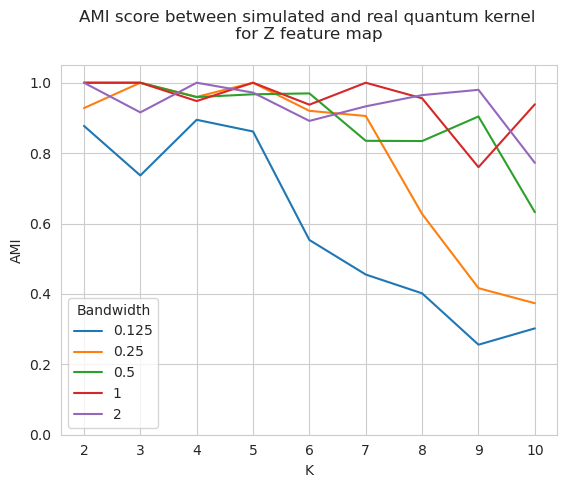

In [15]:
#Plot ARI and NMI
ft_map_to_plot='Z'
score_to_plot='AMI'
sns.set_style("whitegrid")
sns.lineplot(data=df_nmi_ari[df_nmi_ari['ftmap'].isin([ft_map_to_plot])],y=score_to_plot,x='K',hue='Bandwidth',markers=True,palette='tab10')
plt.ylim(0.00,1.05)
plt.title('{} score between simulated and real quantum kernel \n for {} feature map \n'.format(score_to_plot,ft_map_to_plot,df.N_samples[0]))
plt.savefig(outdir+'{}_ftmap_{}_score.png'.format(ft_map_to_plot,score_to_plot))

# Sankey and Survival


## Load and prepare data

In [16]:
#Load original patient index from data and metabric data(metadata)
#Load clustering data
print('#### CASE 1000 samples simulated ####')
df_clust=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_1000_umap/clustering_1000_clusters.csv',index_col=0)
df_clust.columns = df_clust.columns.str.replace("_Z_full", "_Z")
df_clust.replace('Z_full','Z',inplace=True)
data_input = pd.read_csv("Input_data/UMAP_METABRIC_4cmp_IC10_full.csv", sep = ",",index_col=0)
patient_index=data_input.sample(n=1000,axis=0,random_state=42).index
#set index to df_clust to patient index
df_clust.index=patient_index

#Load metadata
metabric = pd.read_csv('/CTGlab/data/brca_metabric/data_clinical_patient.txt', sep='\t', skiprows=[0,1,2,3])
#Remove patients with missing OS_STATUS and merge with data
metabricSubset = metabric.loc[~metabric['OS_STATUS'].isna()]
quantumDf = pd.merge(metabricSubset, df_clust, how='left', right_on=[df_clust.index], left_on=['PATIENT_ID']).dropna(subset=df_clust.columns)
quantumDf['OS_STATUS_censored'] = quantumDf['VITAL_STATUS'].apply(lambda x: 1 if x == "Died of Disease" else 0) 
quantumDf['OS_STATUS'] = quantumDf['OS_STATUS'].apply(lambda x: int(x.split(':')[0]))

#### CASE 1000 samples simulated ####


In [17]:
print('#### CASE 100 samples real ####')
patient_index_100=data_input.sample(n=100,axis=0,random_state=42).index
df_clust_real.index=patient_index_100
quantumDf_real_100 = pd.merge(metabricSubset, df_clust_real, how='left', right_on=[df_clust_real.index], left_on=['PATIENT_ID']).dropna(subset=df_clust_real.columns)
quantumDf_real_100['OS_STATUS_censored'] = quantumDf_real_100['VITAL_STATUS'].apply(lambda x: 1 if x == "Died of Disease" else 0)
quantumDf_real_100['OS_STATUS'] = quantumDf_real_100['OS_STATUS'].apply(lambda x: int(x.split(':')[0]))

#### CASE 100 samples real ####


In [18]:
print('#### CASE 100 samples sim ####')
df_clust_sim.index=patient_index_100
quantumDf_sim_100 = pd.merge(metabricSubset, df_clust_sim, how='left', right_on=[df_clust_sim.index], left_on=['PATIENT_ID']).dropna(subset=df_clust_sim.columns)
quantumDf_sim_100['OS_STATUS_censored'] = quantumDf_sim_100['VITAL_STATUS'].apply(lambda x: 1 if x == "Died of Disease" else 0)
quantumDf_sim_100['OS_STATUS'] = quantumDf_sim_100['OS_STATUS'].apply(lambda x: int(x.split(':')[0]))


#### CASE 100 samples sim ####


## Sankey


- "Best cases" among Most coherent clustering between real and sim (100 samples)

- Select "best cases" from the ideal 1000 sample simulation

### Real 100 samples

In [19]:
#Prepare columns 
cluster_col=[]
for i in quantumDf_real_100.columns:
    if 'Cluster' in i:
        cluster_col.append(i)

In [20]:
#Prepare df for sankey
quantumDf_s=quantumDf_real_100.copy()
for column in quantumDf_s.loc[:, ['INTCLUST','CLAUDIN_SUBTYPE']+cluster_col].columns:
    quantumDf_s[column] = quantumDf_s[column].apply(lambda x: f"{column}_{x}")

To plot:
- first get the clusterings with the best coherence
- checek wich ones have the best silhouette and DI
- plot for confrontation


Note: best_ami_idx below contains the clustering with an AMI==1 and where selected in the section clustering coherence


In [21]:
#The ones with best silhouette
df_real.iloc[best_ami_idx].sort_values(by='silhouette',ascending=False)

Unnamed: 0 ftmap  K  Bandwidth             s  geom_distance  \
108         108     Z  2       0.50   6057.476628       2.091055   
109         109     Z  3       0.50   6057.476628       2.091055   
122         122     Z  7       1.00   4097.149781       3.207312   
100         100     Z  3       0.25  10403.194977       3.860099   
102         102     Z  5       0.25  10403.194977       3.860099   
120         120     Z  5       1.00   4097.149781       3.207312   
118         118     Z  3       1.00   4097.149781       3.207312   
117         117     Z  2       1.00   4097.149781       3.207312   
128         128     Z  4       2.00   6454.449698      10.512267   
126         126     Z  2       2.00   6454.449698      10.512267   

     concentration  silhouette  Score_cluster        CHI        DI   v_intra  \
108       0.066699    0.558708       0.546341  44.248236  0.878541  0.047888   
109       0.066699    0.322350       0.390373  47.500560  0.082701  0.030636   
122       0.053731    0.319908       0.396945  46.765743  0.135121  0.047943   
100       0.019106    0.319376       0.446294  32.530205  0.134315  0.006838   
102       0.019106    0.276013       0.477067  57.298958  0.101108  0.004788   
120       0.053731    0.263627       0.285558  42.044629  0.064890  0.062896   
118       0.053731    0.234614       0.188932  51.586242  0.154200  0.054458   
117       0.053731    0.210122       0.188603  44.248236  0.825989  0.050707   
128       0.023323    0.119377       0.149922   5.631460  0.264826  0.046313   
126       0.023323    0.081838       0.082667   0.604951  0.143146  0.033291   

      v_inter  N_samples  Type  
108  0.000839        100  Real  
109  0.065569        100  Real  
122  0.022372        100  Real  
100  0.042391        100  Real  
102  0.032672        100  Real  
120  0.024372        100  Real  
118  0.009508        100  Real  
117  0.000704        100  Real  
128  0.007921        100  Real  
126  0.008383        100  Real

In [22]:
#plot best 3
cols_name_S=[]
cols_name_S_sel=[]
cols_to_plot=[]
cols_to_plot_full=[]
for i in df_real.iloc[best_ami_idx].sort_values(by='silhouette',ascending=False).itertuples():
    # Save all columns to plot
    name='Cluster_'+i.ftmap+'_'+str((i.K))+'_'+f'{i.Bandwidth:g}'
    name_col='b:{},S:{:.2f}, DI:{:.2f}'.format(i.Bandwidth,i.silhouette,i.DI)
    cols_to_plot_full.append(name)
    cols_name_S.append(name_col)

    # Select only those with K > 3
    if i.K>3:
        cols_to_plot.append(name)
        cols_name_S_sel.append(name_col)
        
    
        

First Plot also the ones with few clusters which are the ones with an higher score

In [23]:
fig = plotSankey(quantumDf_s, cols=cols_to_plot_full,names=cols_name_S, valueToHighlight=['High'], linkVar='CELLULARITY')

We can see from the plot above that plots with k>3 contains subclusters so they can be discharged for further considerations even though they have higher silhouette scores(s) or DI scores. We then plot only those clustering wiyh k>3:

In [24]:
fig = plotSankey(quantumDf_s, cols=cols_to_plot,names=cols_name_S_sel, valueToHighlight=['High'], linkVar='CELLULARITY')

Lets look at the DI following the same considerations

In [25]:
#The ones with best DI
df_real.iloc[best_ami_idx].sort_values(by='DI',ascending=False)

Unnamed: 0 ftmap  K  Bandwidth             s  geom_distance  \
108         108     Z  2       0.50   6057.476628       2.091055   
117         117     Z  2       1.00   4097.149781       3.207312   
128         128     Z  4       2.00   6454.449698      10.512267   
118         118     Z  3       1.00   4097.149781       3.207312   
126         126     Z  2       2.00   6454.449698      10.512267   
122         122     Z  7       1.00   4097.149781       3.207312   
100         100     Z  3       0.25  10403.194977       3.860099   
102         102     Z  5       0.25  10403.194977       3.860099   
109         109     Z  3       0.50   6057.476628       2.091055   
120         120     Z  5       1.00   4097.149781       3.207312   

     concentration  silhouette  Score_cluster        CHI        DI   v_intra  \
108       0.066699    0.558708       0.546341  44.248236  0.878541  0.047888   
117       0.053731    0.210122       0.188603  44.248236  0.825989  0.050707   
128       0.023323    0.119377       0.149922   5.631460  0.264826  0.046313   
118       0.053731    0.234614       0.188932  51.586242  0.154200  0.054458   
126       0.023323    0.081838       0.082667   0.604951  0.143146  0.033291   
122       0.053731    0.319908       0.396945  46.765743  0.135121  0.047943   
100       0.019106    0.319376       0.446294  32.530205  0.134315  0.006838   
102       0.019106    0.276013       0.477067  57.298958  0.101108  0.004788   
109       0.066699    0.322350       0.390373  47.500560  0.082701  0.030636   
120       0.053731    0.263627       0.285558  42.044629  0.064890  0.062896   

      v_inter  N_samples  Type  
108  0.000839        100  Real  
117  0.000704        100  Real  
128  0.007921        100  Real  
118  0.009508        100  Real  
126  0.008383        100  Real  
122  0.022372        100  Real  
100  0.042391        100  Real  
102  0.032672        100  Real  
109  0.065569        100  Real  
120  0.024372        100  Real

In [26]:
cols_to_plot_DI=[]
cols_name_DI=[]
for i in df_real.iloc[best_ami_idx].sort_values(by='DI',ascending=False).itertuples():
    #Select only those with K > 3
    if i.K>3:
        name='Cluster_'+i.ftmap+'_'+str((i.K))+'_'+f'{i.Bandwidth:g}'
        name_col='b:{},S:{:.2f}, DI:{:.2f}'.format(i.Bandwidth,i.silhouette,i.DI)
        cols_name_DI.append(name_col)
        cols_to_plot_DI.append(name)

In [27]:
cols_to_plot_DI

['Cluster_Z_4_2', 'Cluster_Z_7_1', 'Cluster_Z_5_0.25', 'Cluster_Z_5_1']

Below the four best clustering according to the DI score , for K>3

In [28]:
fig=plotSankey(quantumDf_s, cols=cols_to_plot_DI, names=cols_name_DI, valueToHighlight=['High'], linkVar='CELLULARITY')

We move further to compare the 2 best cases for each index

In [29]:
print(cols_to_plot[:2])
print(cols_to_plot_DI[:2])


['Cluster_Z_7_1', 'Cluster_Z_5_0.25']
['Cluster_Z_4_2', 'Cluster_Z_7_1']


In [30]:
#Union of the two sets
cols_to_plot_union=list(set(cols_to_plot[:2])|(set(cols_to_plot_DI[:2])))

In [31]:

fig=plotSankey(quantumDf_s, cols=cols_to_plot_union, valueToHighlight=['High'], linkVar='CELLULARITY')

### Check for batch effect

Looking at the recourring mini-cluster in different stratifications we looked if this difference has been inhereted from the umap DR performed

In [32]:
data_input_100=data_input.sample(n=100,axis=0,random_state=42)


In [33]:
clust=quantumDf_real_100['Cluster_Z_5_0.5']

In [34]:
for i in quantumDf_real_100.PATIENT_ID:
    if i not in data_input_100.index:
        print(i)

In [35]:
data_input_100

Component_1  Component_2  Component_3  Component_4  IntClustMemb
MB-4270     4.459003     1.762128     8.716180     3.800151             9
MB-6068     3.232354     0.750432     9.716409     3.052997             4
MB-0666     4.351296     3.491412     9.277145     2.818116             9
MB-7010     5.542212     4.578652     9.395142     3.620670             7
MB-7036     3.751446     0.916476     9.636867     2.495010            10
...              ...          ...          ...          ...           ...
MB-3351     3.863398     4.373843     9.367185     2.028247             3
MB-0615     4.540109     3.731272    10.014156     2.037181             5
MB-3466     4.534412     3.938404     9.328135     2.299947             2
MB-0301     5.592884     3.783750     9.421013     2.585854             7
MB-5602     4.244184     1.218765     9.299067     2.870626            10

[100 rows x 5 columns]

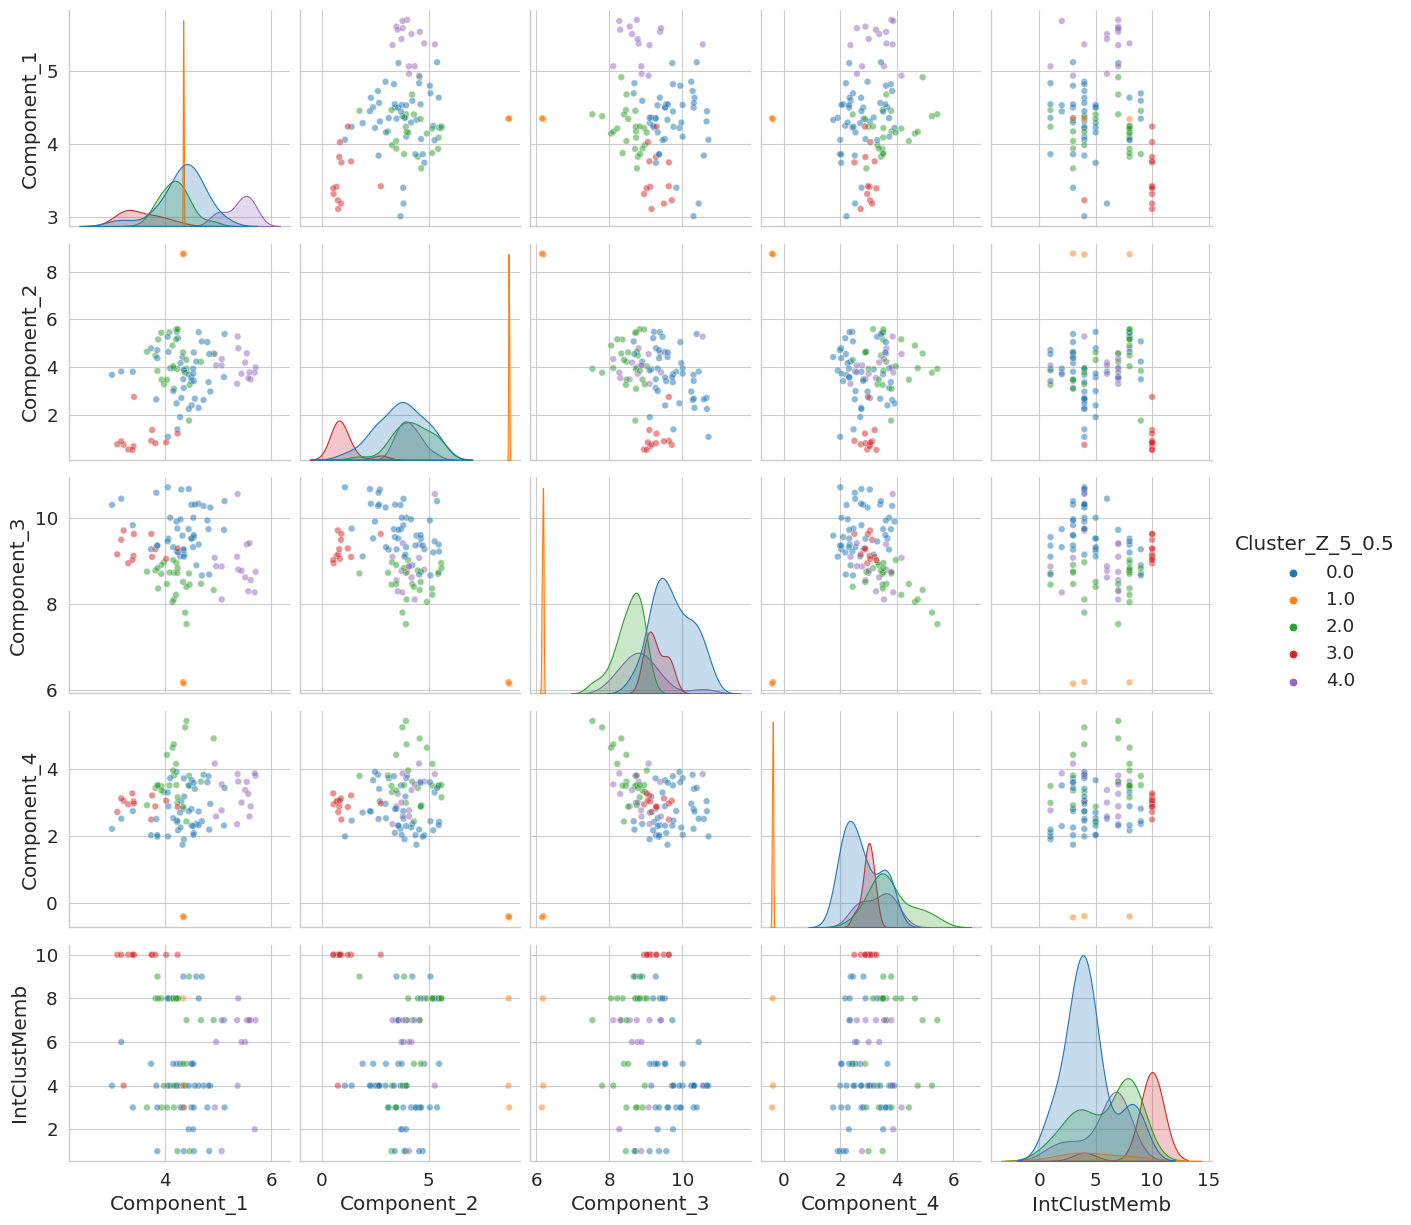

In [36]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
clust='Cluster_Z_5_0.5'
sns.pairplot(data_input_100.merge(quantumDf_real_100[[clust,'PATIENT_ID']],how='left',right_on=['PATIENT_ID'], left_on=[data_input_100.index]), hue=clust, palette='tab10', diag_kind='kde',plot_kws={'alpha':0.5})

Are they immortal?

Text(0, 0.5, 'Overall survival probability')

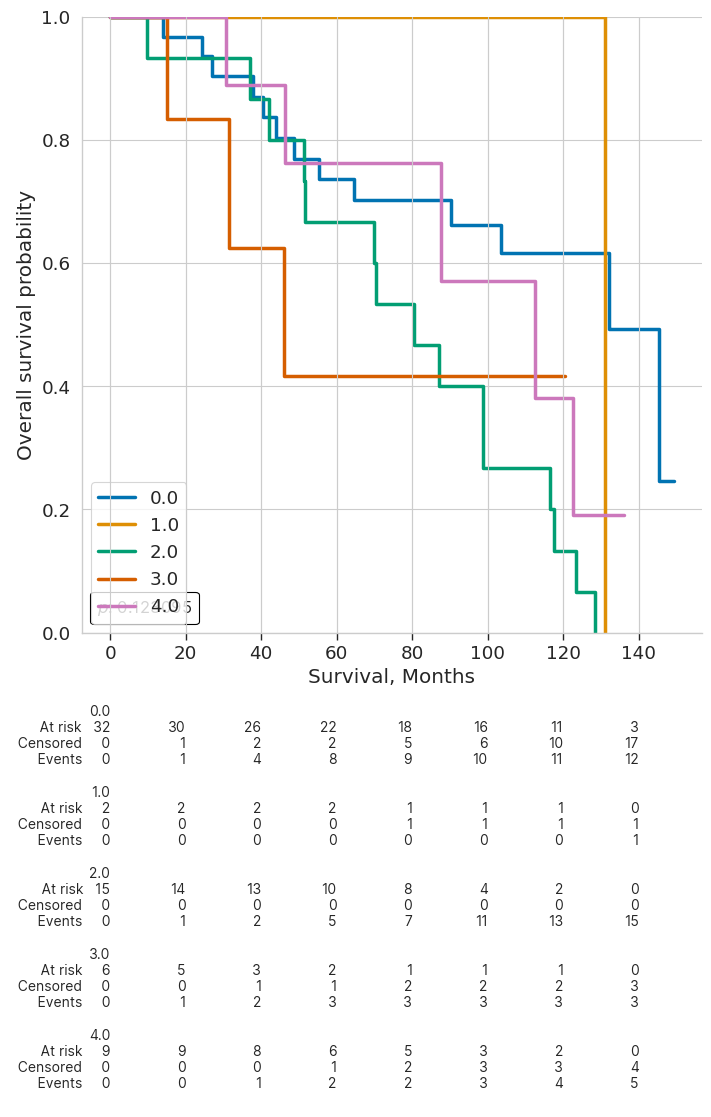

In [37]:
fig, ax = plt.subplots(figsize=(8,8))
plot_KM_curves(
    quantumDf_real_100.loc[quantumDf_real_100['OS_MONTHS'] <150 ], durationVar='OS_MONTHS',eventVar='OS_STATUS', indVar=clust, groups=[1,3], ax=ax, ci_show=False)
ax.set_xlabel('Survival, Months')
ax.set_ylabel('Overall survival probability')

Not immortal  :(
    
They seem to live long enought 

### Simulated 1000

Let's check the highest scoring clusters for the simulatted 1000 case:

- Best ones according to the silhouette score (cut-off=0.3/ max 10 )
- Best ones according to the DI (max 10)

In [38]:
quantumDf_s=quantumDf.copy()
for column in quantumDf_s.loc[:, ['INTCLUST','CLAUDIN_SUBTYPE']+cluster_col].columns:
    quantumDf_s[column] = quantumDf_s[column].apply(lambda x: f"{column}_{x}")

In [39]:
#Drop duplicated rbf cases due to bandwidth
df_sim_1000=df_sim_1000[(df_sim_1000['ftmap'] != 'rbf') | (df_sim_1000['Bandwidth'] == 1)]


Lets start with the silhouette

In [40]:
df_sim_1000.sort_values(by='silhouette',ascending=False,inplace=True)

In [41]:
#Get only the  10 best with silhouette >0.3
df_sim_1000[df_sim_1000['silhouette']>0.3].iloc[:10]


Unnamed: 0      ftmap   K  Bandwidth              s  geom_distance  \
135         135  ZZ_linear   2      0.125  127734.680535       9.484586   
28           28        rbf   3      1.000   74501.173166       2.500972   
136         136  ZZ_linear   3      0.125  127734.680535       9.484586   
27           27        rbf   2      1.000   74501.173166       2.500972   
29           29        rbf   4      1.000   74501.173166       2.500972   
32           32        rbf   7      1.000   74501.173166       2.500972   
30           30        rbf   5      1.000   74501.173166       2.500972   
33           33        rbf   8      1.000   74501.173166       2.500972   
31           31        rbf   6      1.000   74501.173166       2.500972   
152         152  ZZ_linear  10      0.250   74836.101545       5.339809   

     concentration  silhouette  Score_cluster         CHI        DI   v_intra  \
135       0.070194    0.628426       0.624934  154.232887  0.837206  0.056991   
28        0.029959    0.572370       0.620737  529.898257  0.000929  0.008170   
136       0.070194    0.551887       0.584336  408.213514  0.037421  0.025789   
27        0.029959    0.542565       0.548716  670.054354  0.001045  0.019163   
29        0.029959    0.419561       0.616219  547.824164  0.002553  0.005853   
32        0.029959    0.407904       0.719146  507.595970  0.001485  0.003319   
30        0.029959    0.404097       0.652419  525.682252  0.000729  0.005026   
33        0.029959    0.395397       0.734598  482.822831  0.002395  0.003016   
31        0.029959    0.392686       0.680109  481.499765  0.000729  0.004570   
152       0.080288    0.391744       0.602663  321.743957  0.032121  0.026329   

      v_inter  N_samples       Type  
135  0.000647       1000  Simulated  
28   0.032906       1000  Simulated  
136  0.055347       1000  Simulated  
27   0.025802       1000  Simulated  
29   0.032249       1000  Simulated  
32   0.029624       1000  Simulated  
30   0.030578       1000  Simulated  
33   0.029523       1000  Simulated  
31   0.030022       1000  Simulated  
152  0.051701       1000  Simulated

Considering most of these are rbf, and thus not very usefull for us, we can proced and plot only the rbf ones to see cluster consistency between micro and macro clusters and then select one for reference to keep with the quantum

In [42]:
cols_to_plot_rbf=[]
cols_name_rbf=[]

for i in df_sim_1000[(df_sim_1000['silhouette']>0.3) & (df_sim_1000.ftmap=='rbf')].iloc[:10].itertuples():
    name='Cluster_'+i.ftmap+'_'+str((i.K))+'_'+f'{i.Bandwidth:g}'
    name_col='S:{:.2f}'.format(i.silhouette,i.DI)
    cols_name_rbf.append(name_col)
    cols_to_plot_rbf.append(name)

In [43]:
fig=plotSankey(quantumDf_s, cols=cols_to_plot_rbf, names=cols_name_rbf, valueToHighlight=['High'], linkVar='CELLULARITY')

We can see that overall there are two macroclusters (+1 small other) one of which then tend to stratify (cluster 0.0) and the other which seems to be more consistent. we take for reference K=7



In [44]:
rbf_clusters_s='Cluster_rbf_7_1'

Lets move on and take the best 5 quantum clusters

In [45]:
df_sim_1000[(df_sim_1000['silhouette']>0.3) & (df_sim_1000.ftmap!='rbf')].iloc[:5]

Unnamed: 0      ftmap   K  Bandwidth              s  geom_distance  \
135         135  ZZ_linear   2      0.125  127734.680535       9.484586   
136         136  ZZ_linear   3      0.125  127734.680535       9.484586   
152         152  ZZ_linear  10      0.250   74836.101545       5.339809   
151         151  ZZ_linear   9      0.250   74836.101545       5.339809   
150         150  ZZ_linear   8      0.250   74836.101545       5.339809   

     concentration  silhouette  Score_cluster         CHI        DI   v_intra  \
135       0.070194    0.628426       0.624934  154.232887  0.837206  0.056991   
136       0.070194    0.551887       0.584336  408.213514  0.037421  0.025789   
152       0.080288    0.391744       0.602663  321.743957  0.032121  0.026329   
151       0.080288    0.388783       0.573952  360.224697  0.029118  0.031645   
150       0.080288    0.375992       0.558809  229.956558  0.029195  0.035124   

      v_inter  N_samples       Type  
135  0.000647       1000  Simulated  
136  0.055347       1000  Simulated  
152  0.051701       1000  Simulated  
151  0.050712       1000  Simulated  
150  0.051325       1000  Simulated

Since all the best clusters have been done with the ZZ linear we omit these in further plots to improve readability

In [46]:
cols_to_plot_q = []
cols_name_q = []

for i in df_sim_1000[(df_sim_1000['silhouette']>0.3) & (df_sim_1000.ftmap!='rbf')].iloc[:5].itertuples():
    name='Cluster_'+i.ftmap+'_'+str((i.K))+'_'+f'{i.Bandwidth:g}'
    name_col='b:{},S:{:.3f}'.format(i.Bandwidth,i.silhouette)
    cols_name_q.append(name_col)
    cols_to_plot_q.append(name)

In [47]:
fig=plotSankey(quantumDf_s, cols=cols_to_plot_q, names=cols_name_q, valueToHighlight=['High'], linkVar='CELLULARITY')

As for the other cases we see once again how the stratification with lower k rapresents a macrostructure in one data and tend to have a higher value of S due to the bias of the silhouette score.  There seems to be a good consistency also between the finer stratifications (K=10,9,8), and considering they came from the same kernel (ftmap=ZZ_linear, b=0.25) we decide to keep K=10 as a reference since it yields the best silhouette.

In [48]:
q_cluster_s='Cluster_ZZ_linear_10_0.25'

Let's look at the best ones according to the DI

In [49]:
df_sim_1000.sort_values(by='DI',ascending=False,inplace=True)

In [50]:
#Check the  10 best 
df_sim_1000.iloc[:10]


Unnamed: 0      ftmap   K  Bandwidth              s  geom_distance  \
135         135  ZZ_linear   2      0.125  127734.680535       9.484586   
94           94          Z   6      0.125  212056.597796      16.760649   
95           95          Z   7      0.125  212056.597796      16.760649   
96           96          Z   8      0.125  212056.597796      16.760649   
89           89    ZZ_full  10      2.000   90010.792065      25.414386   
93           93          Z   5      0.125  212056.597796      16.760649   
82           82    ZZ_full   3      2.000   90010.792065      25.414386   
105         105          Z   8      0.250  154580.798965       8.371354   
107         107          Z  10      0.250  154580.798965       8.371354   
106         106          Z   9      0.250  154580.798965       8.371354   

     concentration  silhouette  Score_cluster         CHI        DI   v_intra  \
135       0.070194    0.628426       0.624934  154.232887  0.837206  0.056991   
94        0.001171    0.244036       0.475554  450.758446  0.142593  0.001548   
95        0.001171    0.166334       0.435929  306.404099  0.122423  0.002044   
96        0.001171    0.114115       0.432576  262.378658  0.109097  0.002068   
89        0.008016    0.048231       0.092967   38.572960  0.102802  0.020632   
93        0.001171    0.261369       0.452608  482.960746  0.098428  0.002301   
82        0.008016    0.030379       0.039667  116.652572  0.092874  0.011679   
105       0.012575    0.317547       0.614840  437.464558  0.090453  0.001649   
107       0.012575    0.263067       0.611583  315.275127  0.088751  0.001785   
106       0.012575    0.286053       0.602580  345.848264  0.079558  0.002046   

      v_inter  N_samples       Type  
135  0.000647       1000  Simulated  
94   0.015123       1000  Simulated  
95   0.015126       1000  Simulated  
96   0.014980       1000  Simulated  
89   0.005223       1000  Simulated  
93   0.015573       1000  Simulated  
82   0.004883       1000  Simulated  
105  0.020288       1000  Simulated  
107  0.020384       1000  Simulated  
106  0.020407       1000  Simulated

Select the first 5 for plotting

In [51]:
cols_name_q_DI = []
cols_to_plot_q_DI = []
for i in df_sim_1000.iloc[:5].itertuples():
    name='Cluster_'+i.ftmap+'_'+str((i.K))+'_'+f'{i.Bandwidth:g}'
    name_col='b:{},\nDI:{:.3f}'.format(i.Bandwidth,i.DI,i.silhouette)
    cols_name_q_DI.append(name_col)
    cols_to_plot_q_DI.append(name)

In [52]:
print(cols_to_plot_q_DI)

['Cluster_ZZ_linear_2_0.125', 'Cluster_Z_6_0.125', 'Cluster_Z_7_0.125', 'Cluster_Z_8_0.125', 'Cluster_ZZ_full_10_2']


In [53]:
fig=plotSankey(quantumDf_s, cols=cols_to_plot_q_DI, names=cols_name_q_DI, valueToHighlight=['High'], linkVar='CELLULARITY')

As before we can see that the case for K=2 is capturing the macrostructure of the data which consist of a number of subclusters, this phenomenon is due to the DI which is affected by the same bias of the silhouette score. We can also see that we have  a good level of consistency between 2nd 3rd and 4th clustering reported in the plot whereas the 5th is completly different, however it is also the one with the lowest DI and can be discharged from further analysis. Following the same approach used for the silhouette score we will keep the 2nd clustering since its the one with the best DI and considering the remaining fine stratification come form the same Kernel (ftmap:Z,b:0.125)


In [54]:
q_cluster_DI='Cluster_Z_6_0.125'

Now we can put togheter quantum, rbf and known stratification (INTCLUST and CLAUDINE ) and look how they are :

- quantum vs classical
- quantum + claudin
- quantum + intclust


In [55]:
print(q_cluster_s,q_cluster_DI)

Cluster_ZZ_linear_10_0.25 Cluster_Z_6_0.125


In [56]:
fig=plotSankey(quantumDf_s, cols=[q_cluster_DI,rbf_clusters_s,q_cluster_s], names=['Z_0.125 best_DI','rbf','ZZ_linear_0.25 best_s'], valueToHighlight=['High'], linkVar='CELLULARITY')

In [57]:
print('AMI between rbf and ZZ_linear_0.25',adjusted_mutual_info_score(quantumDf_s[rbf_clusters_s],quantumDf_s[q_cluster_s]))
print('AMI between rbf and Z_0.125',adjusted_mutual_info_score(quantumDf_s[rbf_clusters_s],quantumDf_s[q_cluster_DI]))
print('AMI between ZZ_linear_0.25 and Z_0.125',adjusted_mutual_info_score(quantumDf_s[q_cluster_s],quantumDf_s[q_cluster_DI]))

AMI between rbf and ZZ_linear_0.25 0.619543600497348
AMI between rbf and Z_0.125 0.5063765832802456
AMI between ZZ_linear_0.25 and Z_0.125 0.4641176521182337


some consistency is present

Next:
- quantum vs Claudine

In [58]:
fig=plotSankey(quantumDf_s, cols=[q_cluster_s,'CLAUDIN_SUBTYPE',q_cluster_DI], names=['ZZ_linear_0.25 (best_s)','CLAUDIN_SUBTYPE','Z_0.125 (best_DI)'], valueToHighlight=['High'], linkVar='CELLULARITY')

In [59]:
print('AMI between quantum stratifications:',adjusted_mutual_info_score(quantumDf_s[q_cluster_s],quantumDf_s[q_cluster_DI]))
print('AMI between Claudin and ZZ_linear_0.25:',adjusted_mutual_info_score(quantumDf_s[q_cluster_s],quantumDf_s['CLAUDIN_SUBTYPE']))
print('AMI between Claudin and Z_0.125:',adjusted_mutual_info_score(quantumDf_s[q_cluster_DI],quantumDf_s['CLAUDIN_SUBTYPE']))

AMI between quantum stratifications: 0.4641176521182337
AMI between Claudin and ZZ_linear_0.25: 0.2204539149008424
AMI between Claudin and Z_0.125: 0.1956390672955398


Some consistency but not too much we can say

Next:
- quantum vs intclust

In [60]:
fig=plotSankey(quantumDf_s, cols=[q_cluster_s,'INTCLUST',q_cluster_DI], names=['ZZ_linear_0.25 best_s','INTCLUST','Z_0.125 best_DI'], valueToHighlight=['High'], linkVar='CELLULARITY')

In [61]:
print('AMI between INTCLUST and ZZ_linear_0.25:', adjusted_mutual_info_score(quantumDf_s[q_cluster_s],quantumDf_s['INTCLUST']))
print('AMI between INTCLUST and Z_0.125:', adjusted_mutual_info_score(quantumDf_s[q_cluster_DI],quantumDf_s['INTCLUST']))

AMI between INTCLUST and ZZ_linear_0.25: 0.22356490851066763
AMI between INTCLUST and Z_0.125: 0.19199088944027898


Very different again

In [62]:
fig=plotSankey(quantumDf_s, cols=[q_cluster_s,q_cluster_DI]+['INTCLUST','CLAUDIN_SUBTYPE'] , valueToHighlight=['High'], linkVar='CELLULARITY')

Well they are  not even coherent  between themselfs :(

In [63]:
print('AMI between CLAUDIN and INTCLUST:', adjusted_mutual_info_score(quantumDf_s['CLAUDIN_SUBTYPE'],quantumDf_s['INTCLUST']))

AMI between CLAUDIN and INTCLUST: 0.24130552243880443


## Survival

Lets now check how the selected clusters behave in terms of survival:


In [64]:
quantumDf['OS_MONTHS'].describe()

count    1000.000000
mean      128.472167
std        75.786077
min         0.000000
25%        64.541667
50%       122.733333
75%       186.558333
max       355.200000
Name: OS_MONTHS, dtype: float64

In [65]:
print('Best rbf: ', rbf_clusters_s )
print('Best quantum according tu Silhouette: ', q_cluster_s)
print('Best quantum according tu DI: ', q_cluster_DI)

Best rbf:  Cluster_rbf_7_1
Best quantum according tu Silhouette:  Cluster_ZZ_linear_10_0.25
Best quantum according tu DI:  Cluster_Z_6_0.125


In [66]:
quantumDf

PATIENT_ID  LYMPH_NODES_EXAMINED_POSITIVE    NPI CELLULARITY  \
0       MB-0000                           10.0  6.044         NaN   
2       MB-0005                            1.0  4.030        High   
3       MB-0006                            3.0  4.050    Moderate   
6       MB-0014                            1.0  4.020    Moderate   
7       MB-0020                            NaN  6.130        High   
...         ...                            ...    ...         ...   
1972    MB-7291                           22.0  6.100        High   
1973    MB-7292                            1.0  4.030        High   
1974    MB-7293                            1.0  5.090        High   
1976    MB-7295                            1.0  5.050        High   
1979    MB-7298                           12.0  5.050    Moderate   

     CHEMOTHERAPY  COHORT    ER_IHC HER2_SNP6 HORMONE_THERAPY  \
0              NO     1.0   Positve   NEUTRAL             YES   
2             YES     1.0   Positve   NEUTRAL             YES   
3             YES     1.0   Positve   NEUTRAL             YES   
6             YES     1.0   Positve      LOSS             YES   
7             YES     1.0  Negative   NEUTRAL              NO   
...           ...     ...       ...       ...             ...   
1972           NO     4.0   Positve      GAIN             YES   
1973           NO     4.0   Positve      GAIN             YES   
1974           NO     4.0   Positve   NEUTRAL             YES   
1976           NO     4.0   Positve   NEUTRAL             YES   
1979           NO     4.0   Positve   NEUTRAL             YES   

     INFERRED_MENOPAUSAL_STATE  ... Cluster_ZZ_linear_2_2  \
0                         Post  ...                   1.0   
2                          Pre  ...                   0.0   
3                          Pre  ...                   1.0   
6                         Post  ...                   1.0   
7                         Post  ...                   1.0   
...                        ...  ...                   ...   
1972                      Post  ...                   1.0   
1973                      Post  ...                   1.0   
1974                      Post  ...                   1.0   
1976                       Pre  ...                   1.0   
1979                      Post  ...                   1.0   

     Cluster_ZZ_linear_3_2  Cluster_ZZ_linear_4_2  Cluster_ZZ_linear_5_2  \
0                      0.0                    3.0                    4.0   
2                      2.0                    2.0                    3.0   
3                      0.0                    1.0                    1.0   
6                      0.0                    1.0                    1.0   
7                      2.0                    0.0                    2.0   
...                    ...                    ...                    ...   
1972                   2.0                    0.0                    1.0   
1973                   0.0                    0.0                    1.0   
1974                   0.0                    1.0                    1.0   
1976                   1.0                    1.0                    4.0   
1979                   0.0                    0.0                    1.0   

      Cluster_ZZ_linear_6_2 Cluster_ZZ_linear_7_2 Cluster_ZZ_linear_8_2  \
0                       4.0                   6.0                   7.0   
2                       3.0                   4.0                   5.0   
3                       4.0                   0.0                   2.0   
6                       4.0                   0.0                   2.0   
7                       1.0                   1.0                   4.0   
...                     ...                   ...                   ...   
1972                    1.0                   2.0                   4.0   
1973                    4.0                   0.0                   2.0   
1974                    4.0                   0.0                   2.0   

Text(0, 0.5, 'Overall survival probability')

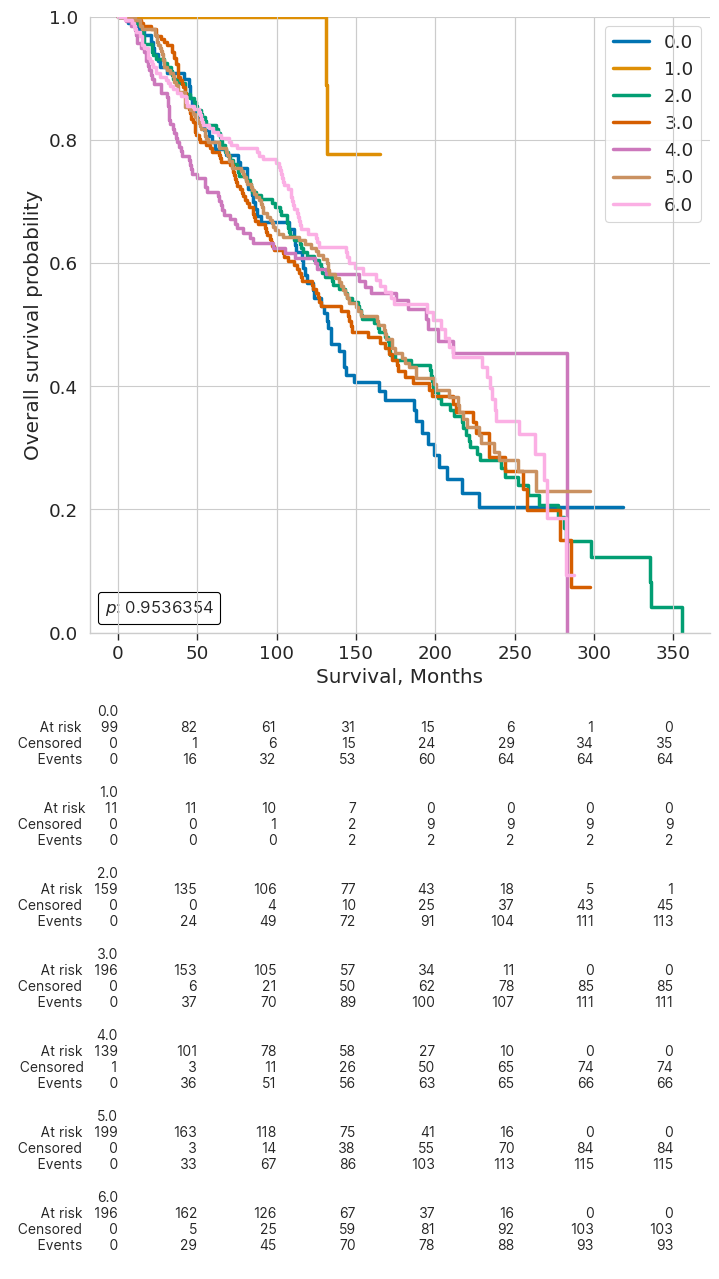

In [67]:
#Survival for best classical case
fig, ax = plt.subplots(figsize=(8,8))
plot_KM_curves(
    quantumDf, durationVar='OS_MONTHS',eventVar='OS_STATUS', indVar=rbf_clusters_s, groups=list(range(0,7)), ax=ax, ci_show=False)
ax.set_xlabel('Survival, Months')
ax.set_ylabel('Overall survival probability')


Text(0, 0.5, 'Overall survival probability')

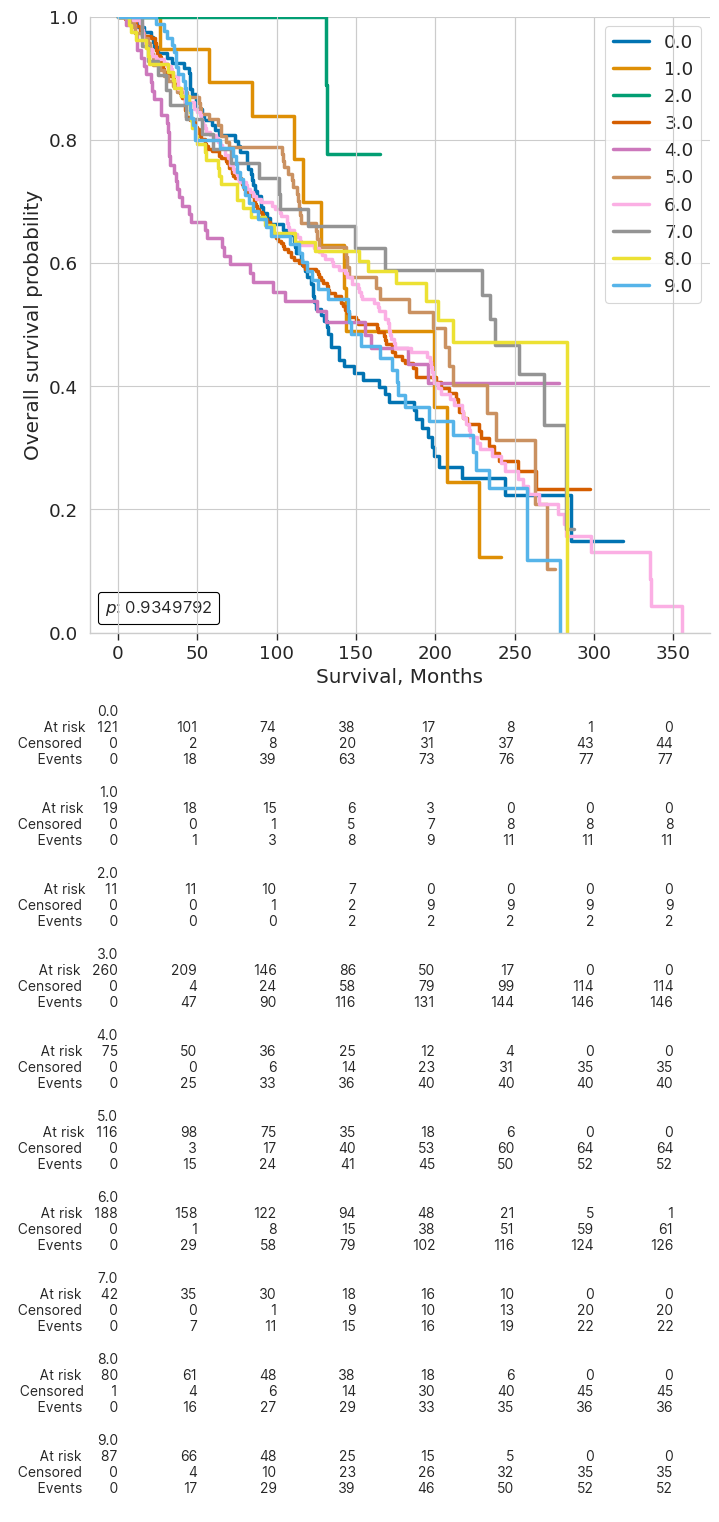

In [68]:
#Plot survival for best quantum case according to silhouette
fig, ax = plt.subplots(figsize=(8,8))
plot_KM_curves(
    quantumDf, durationVar='OS_MONTHS',eventVar='OS_STATUS', indVar=q_cluster_s, groups=list(range(0,10)), ax=ax, ci_show=False)
ax.set_xlabel('Survival, Months')
ax.set_ylabel('Overall survival probability')

Text(0, 0.5, 'Overall survival probability')

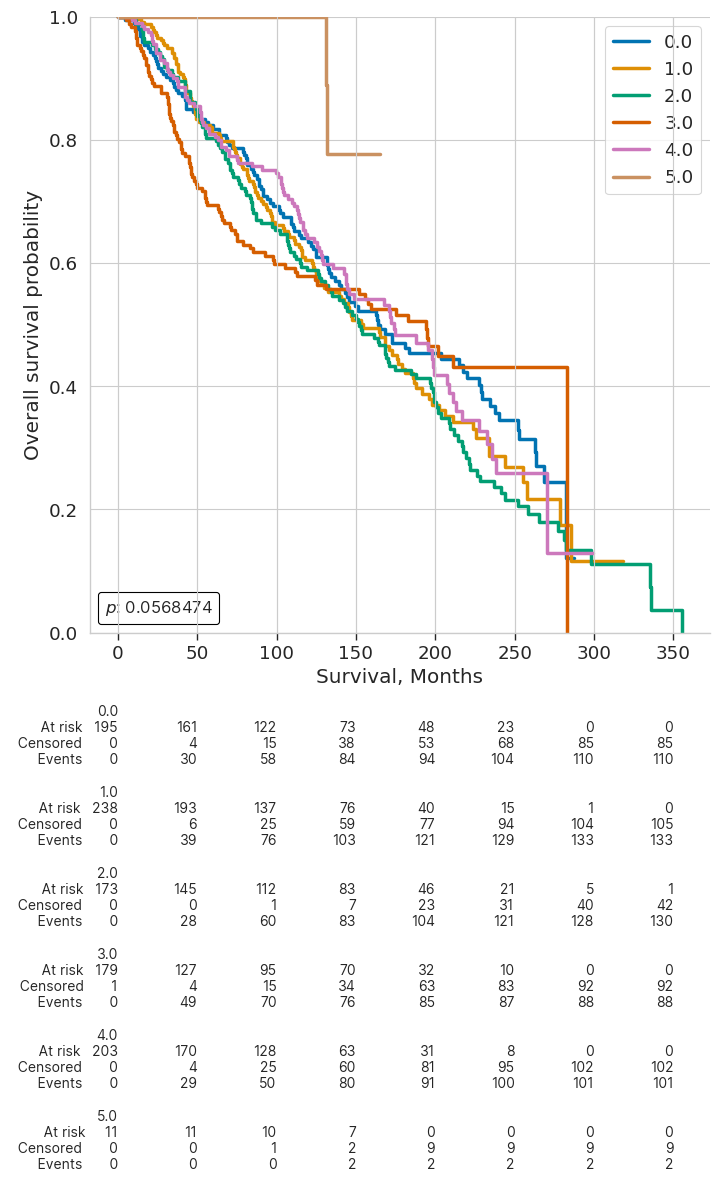

In [69]:
#Plot survival for best quantum case according to DI
fig, ax = plt.subplots(figsize=(8,8))
plot_KM_curves(
    quantumDf, durationVar='OS_MONTHS',eventVar='OS_STATUS', indVar=q_cluster_DI, groups=list(range(0,6)), ax=ax, ci_show=False)
ax.set_xlabel('Survival, Months')
ax.set_ylabel('Overall survival probability')


# Sample complexity

In [70]:
#check intersection between two sampling sizes
print('Intersection between 100 and 1000 samples:',len(set(df_clust_sim.index)&set(df_clust.index)))


Intersection between 100 and 1000 samples: 100


Good grief! Is this a good thing? 

Note: this could have been obvious if we think about how the sampling is done. Since I've fixed the random seed it simply takes a number N of samples in a random order which is fixed by the random seed, so if i want to select n < N sample it just takes the first n samples. 

Here maybe is a clearer example:

In [71]:
# check sampling intersection with random seed
test_1=data_input.sample(n=1000,axis=0,random_state=42)
test_2=data_input.sample(n=10,axis=0,random_state=42)
print('Intersection between test sampling:',len(set(test_1.index)&set(test_2.index)))

Intersection between test sampling: 10


Okay! back to our analysis

We can check:

-AMI and ARI for every case(?)

-Sankey for the best qclusters


In [72]:
#Merge df_clust_sim and df_clust
df_sampling=df_clust.join(df_clust_sim,how='inner',lsuffix='_1000',rsuffix='_100')



In [73]:
#Caluculate ari and ami between same clusterings
ami_ari_dict_list=[]
for col in df_sampling.columns:
    if '_1000' not in col:
        break

    clust=col.split('_')
  

    if clust[1]=='Z':
        ftmap=clust[1]

        
    elif clust[1]=='ZZ':
        ftmap=clust[1]+'_'+clust[2]
    else:
        ftmap='rbf'
    
 
    ari=adjusted_rand_score(df_sampling['_'.join(clust[:-1])+'_1000'],df_sampling['_'.join(clust[:-1])+'_100'])
    nmi=normalized_mutual_info_score(df_sampling['_'.join(clust[:-1])+'_1000'],df_sampling['_'.join(clust[:-1])+'_100'])
    ami=adjusted_mutual_info_score(df_sampling['_'.join(clust[:-1])+'_1000'],df_sampling['_'.join(clust[:-1])+'_100'])
    


    ami_ari_dict_list.append({'ftmap':ftmap,
                              'K':clust[-3],
                              'Bandwidth':clust[-2],
                              'ARI':ari,
                              'NMI':nmi,
                              'AMI':ami})

In [74]:
#List of dictionaries to dataframe
df_nmi_ari_sample=pd.DataFrame(ami_ari_dict_list)

In [75]:
df_nmi_ari_sample

ftmap   K Bandwidth       ARI       NMI       AMI
0          rbf   2     0.125 -0.036213  0.025203  0.007628
1          rbf   3     0.125  0.960132  0.930571  0.928469
2          rbf   4     0.125  0.749738  0.814390  0.805991
3          rbf   5     0.125  0.476494  0.637160  0.613408
4          rbf   6     0.125  0.603511  0.739067  0.715228
..         ...  ..       ...       ...       ...       ...
175  ZZ_linear   6         2  0.149792  0.288728  0.222347
176  ZZ_linear   7         2  0.133620  0.332845  0.247883
177  ZZ_linear   8         2  0.150828  0.385798  0.281938
178  ZZ_linear   9         2  0.179443  0.433988  0.310469
179  ZZ_linear  10         2  0.144174  0.388300  0.224831

[180 rows x 6 columns]

Text(0.5, 1.0, 'AMI score between 100 and 1000 samples')

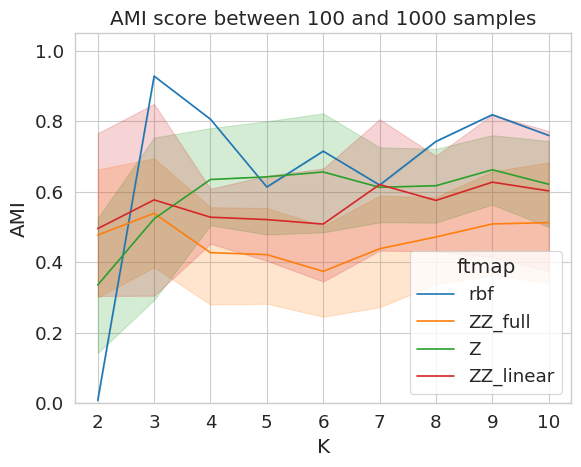

In [76]:
#Plot
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.lineplot(data=df_nmi_ari_sample,
             y='AMI',x='K',hue='ftmap',markers=True,palette='tab10')
plt.ylim(0.00,1.05)
plt.title('AMI score between 100 and 1000 samples')


In [77]:
df_nmi_ari_sample[r'$\beta$']=df_nmi_ari_sample['Bandwidth'].map({'0.125':r'$\frac{\pi}{8}$','0.25':r'$\frac{\pi}{4}$','0.5':r'$\frac{\pi}{2}$','1':r'$\pi$','2':r'$2\pi$'})

In [78]:
df_nmi_ari_sample

ftmap   K Bandwidth       ARI       NMI       AMI          $\beta$
0          rbf   2     0.125 -0.036213  0.025203  0.007628  $\frac{\pi}{8}$
1          rbf   3     0.125  0.960132  0.930571  0.928469  $\frac{\pi}{8}$
2          rbf   4     0.125  0.749738  0.814390  0.805991  $\frac{\pi}{8}$
3          rbf   5     0.125  0.476494  0.637160  0.613408  $\frac{\pi}{8}$
4          rbf   6     0.125  0.603511  0.739067  0.715228  $\frac{\pi}{8}$
..         ...  ..       ...       ...       ...       ...              ...
175  ZZ_linear   6         2  0.149792  0.288728  0.222347           $2\pi$
176  ZZ_linear   7         2  0.133620  0.332845  0.247883           $2\pi$
177  ZZ_linear   8         2  0.150828  0.385798  0.281938           $2\pi$
178  ZZ_linear   9         2  0.179443  0.433988  0.310469           $2\pi$
179  ZZ_linear  10         2  0.144174  0.388300  0.224831           $2\pi$

[180 rows x 7 columns]

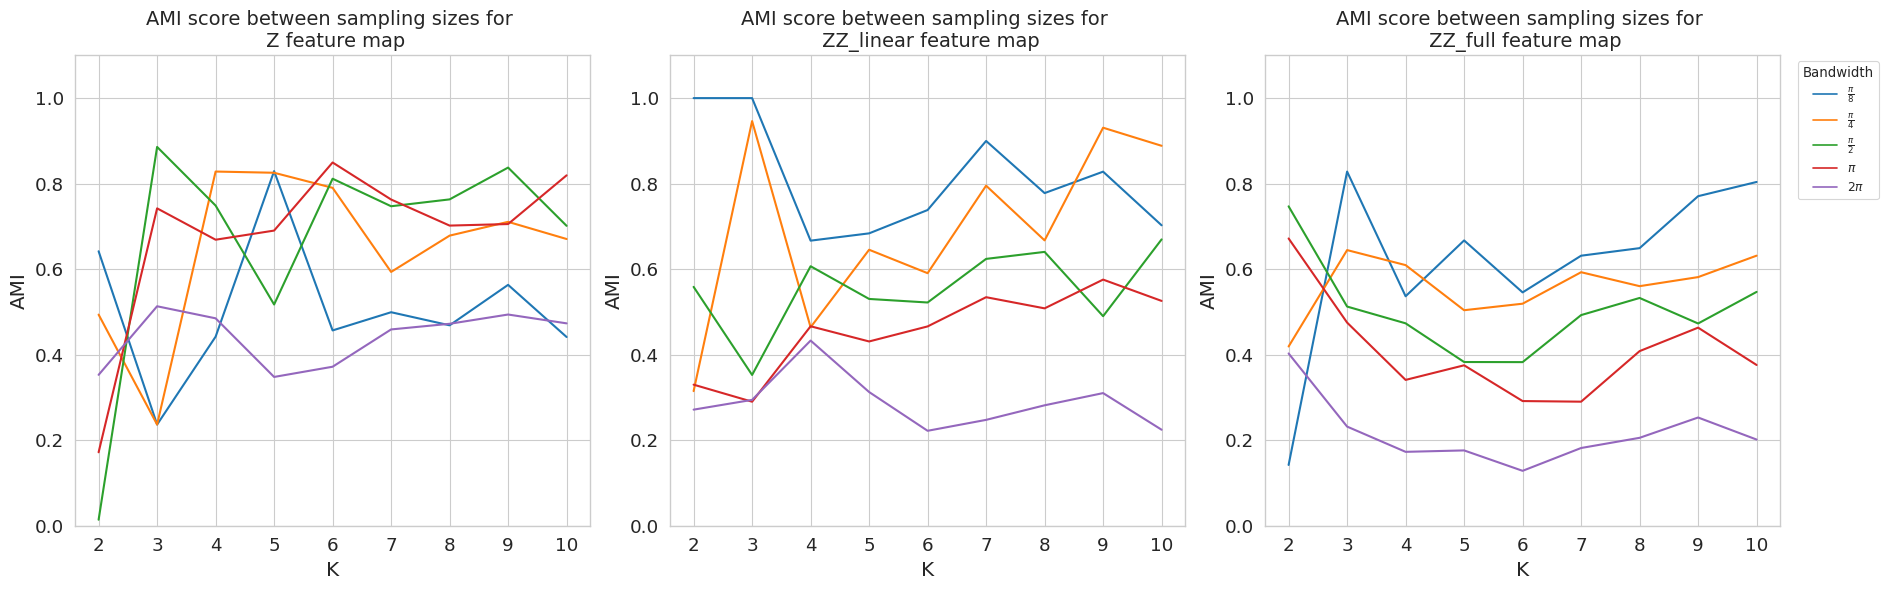

In [79]:
    
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
score_to_plot='AMI'
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":14,"axes.labelsize":9})
# Iterate over each feature map
for i, ft_map in enumerate(['Z', 'ZZ_linear', 'ZZ_full']):
    # Filter the dataframe for the current feature map
    #ft_map_df = df[df['ftmap'] == ft_map]
    
    # Plot the data in the corresponding subplot
    ax = axs[i]
    sns.lineplot(data=df_nmi_ari_sample[df_nmi_ari_sample['ftmap'].isin([ft_map])], x='K',
                  y=score_to_plot, hue=r'$\beta$', markers=True, palette='tab10', ax=ax,linewidth = 1.5)
    
    # Move the legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set the plot title
    ax.set_title('{} score between sampling sizes for \n {} feature map'.format(score_to_plot, ft_map))
    
    # Set the y-axis limits
    ax.set_ylim(0, 1.1)

    if i != 4:
        ax.legend_.remove()

# Get handles and labels for legend from the last axis
handles, labels = ax.get_legend_handles_labels()

# Add a single legend outside the subplots
fig.legend(handles, labels, loc='upper right', title='Bandwidth',bbox_to_anchor=(1.05, 0.9))

# Adjust the plot layout
plt.tight_layout()
#plt.savefig(dir_paper+'{}_coherence.png'.format(score_to_plot), dpi=300)

# Show the plot
plt.show()


In [80]:
df_nmi_ari_sample.sort_values(by='AMI',ascending=False)

ftmap  K Bandwidth       ARI       NMI       AMI          $\beta$
135  ZZ_linear  2     0.125  1.000000  1.000000  1.000000  $\frac{\pi}{8}$
136  ZZ_linear  3     0.125  1.000000  1.000000  1.000000  $\frac{\pi}{8}$
145  ZZ_linear  3      0.25  0.963616  0.947567  0.946266  $\frac{\pi}{4}$
151  ZZ_linear  9      0.25  0.934655  0.942414  0.930837  $\frac{\pi}{4}$
1          rbf  3     0.125  0.960132  0.930571  0.928469  $\frac{\pi}{8}$
..         ... ..       ...       ...       ...       ...              ...
36         rbf  2         2 -0.036213  0.025203  0.007628           $2\pi$
27         rbf  2         1 -0.036213  0.025203  0.007628            $\pi$
18         rbf  2       0.5 -0.036213  0.025203  0.007628  $\frac{\pi}{2}$
9          rbf  2      0.25 -0.036213  0.025203  0.007628  $\frac{\pi}{4}$
0          rbf  2     0.125 -0.036213  0.025203  0.007628  $\frac{\pi}{8}$

[180 rows x 7 columns]

In [81]:
df_sim['Bandwidth']=df_sim['Bandwidth'].astype(float)
df_sim['K']=df_sim['K'].astype(int)
df_nmi_ari_sample['Bandwidth']=df_nmi_ari_sample['Bandwidth'].astype(float)
df_nmi_ari_sample['K']=df_nmi_ari_sample['K'].astype(int)

In [82]:
df=df_nmi_ari_sample.merge(df_sim_1000,left_on=['ftmap','K','Bandwidth'],right_on=['ftmap','K','Bandwidth'])

(0.0, 1.05)

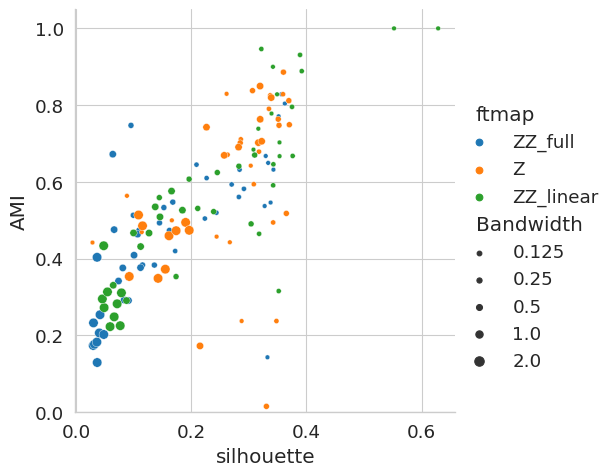

In [83]:
#Plot
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.relplot(data=df[df.ftmap!='rbf'],
             y='AMI',x='silhouette',hue='ftmap',size='Bandwidth',markers=True,palette='tab10')
plt.ylim(0.00,1.05)


In [85]:
df

ftmap   K  Bandwidth       ARI       NMI       AMI $\beta$  \
0          rbf   2        1.0 -0.036213  0.025203  0.007628     NaN   
1          rbf   3        1.0  0.960132  0.930571  0.928469     NaN   
2          rbf   4        1.0  0.749738  0.814390  0.805991     NaN   
3          rbf   5        1.0  0.476494  0.637160  0.613408     NaN   
4          rbf   6        1.0  0.603511  0.739067  0.715228     NaN   
..         ...  ..        ...       ...       ...       ...     ...   
139  ZZ_linear   6        2.0  0.149792  0.288728  0.222347     NaN   
140  ZZ_linear   7        2.0  0.133620  0.332845  0.247883     NaN   
141  ZZ_linear   8        2.0  0.150828  0.385798  0.281938     NaN   
142  ZZ_linear   9        2.0  0.179443  0.433988  0.310469     NaN   
143  ZZ_linear  10        2.0  0.144174  0.388300  0.224831     NaN   

     Unnamed: 0             s  geom_distance  concentration  silhouette  \
0            27  74501.173166       2.500972       0.029959    0.542565   
1            28  74501.173166       2.500972       0.029959    0.572370   
2            29  74501.173166       2.500972       0.029959    0.419561   
3            30  74501.173166       2.500972       0.029959    0.404097   
4            31  74501.173166       2.500972       0.029959    0.392686   
..          ...           ...            ...            ...         ...   
139         175  95407.786367      30.625621       0.012059    0.059177   
140         176  95407.786367      30.625621       0.012059    0.066313   
141         177  95407.786367      30.625621       0.012059    0.071467   
142         178  95407.786367      30.625621       0.012059    0.078879   
143         179  95407.786367      30.625621       0.012059    0.076810   

     Score_cluster         CHI        DI   v_intra   v_inter  N_samples  \
0         0.548716  670.054354  0.001045  0.019163  0.025802       1000   
1         0.620737  529.898257  0.000929  0.008170  0.032906       1000   
2         0.616219  547.824164  0.002553  0.005853  0.032249       1000   
3         0.652419  525.682252  0.000729  0.005026  0.030578       1000   
4         0.680109  481.499765  0.000729  0.004570  0.030022       1000   
..             ...         ...       ...       ...       ...        ...   
139       0.092081   18.865565  0.057337  0.024971  0.006753       1000   
140       0.108621   19.229838  0.036725  0.027800  0.006833       1000   
141       0.120354   17.781279  0.069038  0.030029  0.006863       1000   
142       0.129285   14.854635  0.040077  0.032118  0.006810       1000   
143       0.137537   22.698114  0.059592  0.033233  0.006988       1000   

          Type  
0    Simulated  
1    Simulated  
2    Simulated  
3    Simulated  
4    Simulated  
..         ...  
139  Simulated  
140  Simulated  
141  Simulated  
142  Simulated  
143  Simulated  

[144 rows x 19 columns]

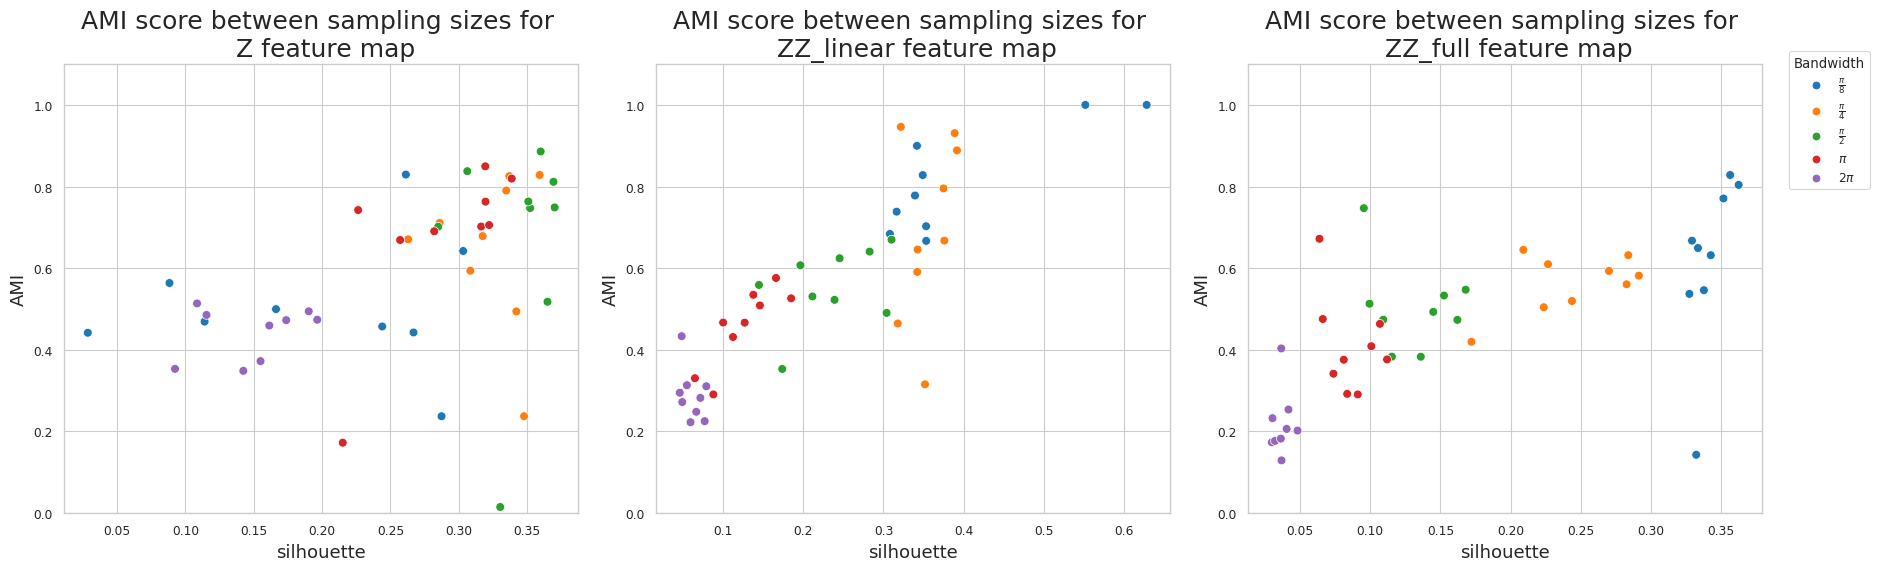

In [90]:
    
# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
score_to_plot='AMI'
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":18,"axes.labelsize":13,})
# Iterate over each feature map
for i, ft_map in enumerate(['Z', 'ZZ_linear', 'ZZ_full']):
    # Filter the dataframe for the current feature map
    #ft_map_df = df[df['ftmap'] == ft_map]
    
    # Plot the data in the corresponding subplot
    ax = axs[i]
    sns.scatterplot(data=df[df['ftmap'].isin([ft_map])], x='silhouette',
                  y=score_to_plot, hue=r'$\beta$', markers=True, palette='tab10', ax=ax, s=40)
    
    # Move the legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set the plot title
    ax.set_title('{} score between sampling sizes for \n {} feature map'.format(score_to_plot, ft_map))
    
    # Set the y-axis limits
    ax.set_ylim(0, 1.1)
    #ax.set_xlim(0,0.4)

    if i != 4:
        ax.legend_.remove()

# Get handles and labels for legend from the last axis
handles, labels = ax.get_legend_handles_labels()

# Add a single legend outside the subplots
fig.legend(handles, labels, loc='upper right', title='Bandwidth',bbox_to_anchor=(1.05, 0.9))

# Adjust the plot layout
plt.tight_layout()
#plt.savefig(dir_paper+'{}_coherence.png'.format(score_to_plot), dpi=300)

# Show the plot
plt.show()


Sankey plot

In [77]:
###Sankey plot
quantumDf_sample=df_sampling.copy()

#Prepare columns
cluster_col_sample=[]
for i in quantumDf_sample.columns:
    if 'Cluster' in i:
        cluster_col_sample.append(i)
#prepare df for sankey
for column in quantumDf_sample.columns:
    quantumDf_sample[column] = quantumDf_sample[column].apply(lambda x: f"{column}_{x}")


In [78]:
#plot for quantum clustering (best silhouette)
fig = plotSankey(quantumDf_sample, cols=[q_cluster_s+'_1000',q_cluster_s+'_100'],names=['ZZ_linear_0.25 1000 samples','ZZ_linear_0.25 100 samples'])

In [79]:
print('AMI between ZZ_linear_0.25 1000 and ZZ_linear_0.25 100:',adjusted_mutual_info_score(quantumDf_sample[q_cluster_s+'_1000'],quantumDf_sample[q_cluster_s+'_100']))

AMI between ZZ_linear_0.25 1000 and ZZ_linear_0.25 100: 0.888533893993951


In [80]:
#plot for quantum clustering (best DI)
fig = plotSankey(quantumDf_sample, cols=[q_cluster_DI+'_1000',q_cluster_DI+'_100'],names=['Z_0.125 1000 samples','Z_0.125 100 samples'])

In [81]:
print('AMI between Z_0.125 1000 and Z_0.125 100:',adjusted_mutual_info_score(quantumDf_sample[q_cluster_DI+'_1000'],quantumDf_sample[q_cluster_DI+'_100']))

AMI between Z_0.125 1000 and Z_0.125 100: 0.45696903393889365


In [82]:
#plot for classical clustering
fig = plotSankey(quantumDf_sample, cols=[rbf_clusters_s+'_1000',rbf_clusters_s+'_100'],names=['rbf 1000 samples','rbf 100 samples'])

In [83]:
print('AMI between rbf 1000 and rbf 100:',adjusted_mutual_info_score(quantumDf_sample[rbf_clusters_s+'_1000'],quantumDf_sample[rbf_clusters_s+'_100']))

AMI between rbf 1000 and rbf 100: 0.6189432984522432


So for now we can say that the quantum cluster for ZZ_linear(best s) is more stable than the classical one and the Z (best DI).
We have to thik about other specific metrics to evaluate the possible advantage in terms of sample complexity. 